# Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

import pickle

C:\Users\tibec\AppData\Local\Temp\ipykernel_20324\2309805833.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data_prepared.csv')
df.sort_values(by='date', inplace=True)
print(df.shape)
df.head()

(4380, 78)


,date,water_temp,cloudiness_0,precipitation_0,temp_0,wind_dir_0,wind_speed_0,wind_dir_x_0,wind_dir_y_0,pressure_0,...,temp_24,wind_dir_24,wind_speed_24,wind_dir_x_24,wind_dir_y_24,pressure_24,month,day,day_length,solar_elevation
0,2011-01-01,0.3,пасмурно,без осадков,-1.0,З,3.0,-5.510911e-16,-3.000000e+00,754.0,...,-3.0,ЮВ,2.0,-1.414214,1.414214e+00,754.0,1,1,6.168333,7.600029
1,2011-01-02,0.3,малооблачно,слабые осадки,-3.0,ЮВ,2.0,-1.414214e+00,1.414214e+00,754.0,...,-4.0,ЮВ,1.0,-0.707107,7.071068e-01,754.0,1,2,6.199444,7.684113
2,2011-01-03,0.2,пасмурно,без осадков,-4.0,ЮВ,1.0,-7.071068e-01,7.071068e-01,754.0,...,-5.0,ЮЮЗ,2.0,-1.847759,-7.653669e-01,753.0,1,3,6.233333,7.775738
3,2011-01-04,2.3,ясно,без осадков,-5.0,ЮЮЗ,2.0,-1.847759e+00,-7.653669e-01,753.0,...,-5.0,Ю,2.0,-2.000000,2.449294e-16,753.0,1,4,6.269722,7.874868
4,2011-01-05,2.1,пасмурно,без осадков,-5.0,Ю,2.0,-2.000000e+00,2.449294e-16,753.0,...,-5.0,ЮЗ,1.0,-0.707107,-7.071068e-01,755.0,1,5,6.308333,7.981454


In [3]:
cloudiness_rate = {
    'ясно': 0,
    'малооблачно': 1,
    'облачно': 2,
    'пасмурно': 3
}

precipitation_rate = {
    'без осадков': 0,
    'пасмурно' : 1,
    'слабый дождь': 2,
    'слабый снег': 2,
    'слабые осадки': 2,
    'дождь': 3,
    'снег': 3,
    'осадки': 3,
    'сильный дождь': 4,
    'сильный снег': 4,
    'сильные осадки': 4
}

In [4]:
df['mean_temp'] = sum([df[f'temp_{i}'] for i in range(0, 24, 3)]) / 8
df['mean_pressure'] = sum([df[f'pressure_{i}'] for i in range(0, 24, 3)]) / 8
df['mean_wind_speed'] = sum([df[f'wind_speed_{i}'] for i in range(0, 24, 3)]) / 8
for i in range(0, 24, 3):
    df[f'cloudiness_{i}'] = df[f'cloudiness_{i}'].map(cloudiness_rate).astype('int')
    df[f'precipitation_{i}'] = df[f'precipitation_{i}'].map(precipitation_rate).astype('int')
df['mean_cloudiness'] = sum([df[f'cloudiness_{i}'] for i in range(0, 24, 3)]) / 8
df['mean_precipitation'] = sum([df[f'precipitation_{i}'] for i in range(0, 24, 3)]) / 8

<Axes: xlabel='date'>

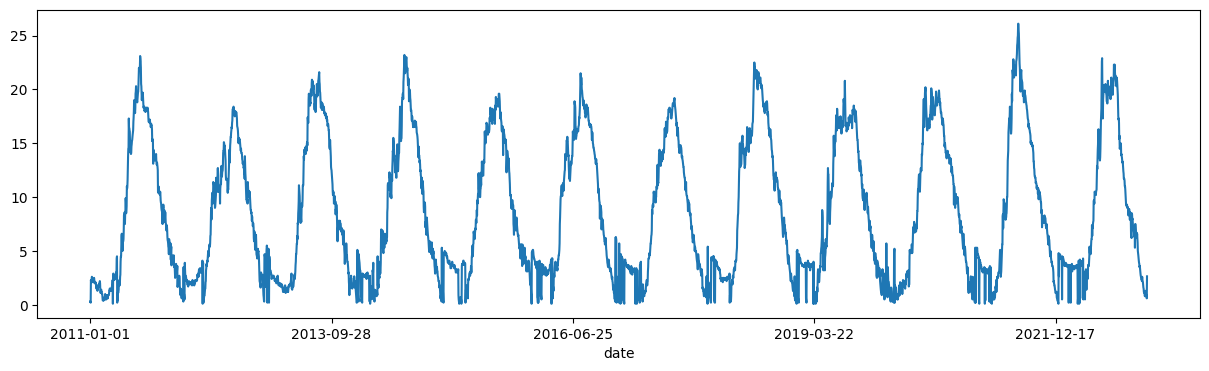

In [5]:
plt.figure(figsize=(15,4))
df.groupby('date')['water_temp'].mean().plot()

In [6]:
def regression_coefs(X, y):
    w0 = np.cov(X, y, ddof=0)[0, 1] / np.var(X, ddof=0)
    w1 = np.mean(y) - w0 * np.mean(X)
    return w0, w1

In [7]:
N = df.shape[0]
water_temp = df.groupby('date')['water_temp'].mean().values
air_temp = df.groupby('date')['mean_temp'].mean().values

Среднее увеличение температуры воды в год: 0.12394667703682333
Среднее увеличение температуры воздуха в год: 0.05379339743715721


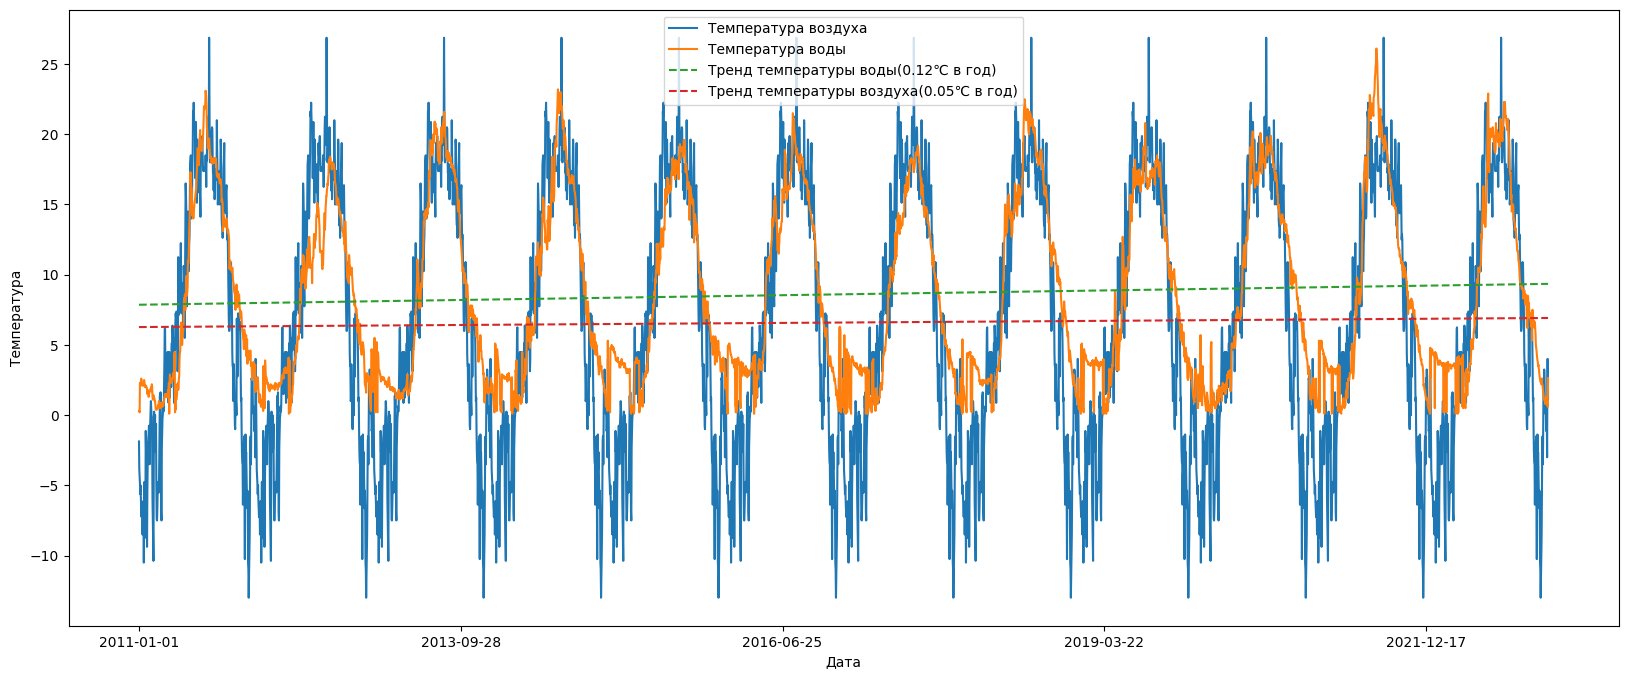

In [25]:
plt.figure(figsize=(20, 8))
df.groupby('date')['mean_temp'].mean().plot(label='Температура воздуха')
df.groupby('date')['water_temp'].mean().plot(label='Температура воды')

w0, w1 = regression_coefs(np.arange(N), water_temp)
print(f'Среднее увеличение температуры воды в год: {w0 * 365}')
water_temp_trend = w0 * np.arange(N) + w1
plt.plot(np.arange(N), water_temp_trend, label=f'Тренд температуры воды({w0 * 365:.2f}℃ в год)', linestyle='--') 

w0, w1 = regression_coefs(np.arange(N), air_temp)
print(f'Среднее увеличение температуры воздуха в год: {w0 * 365}')
air_temp_trend = w0 * np.arange(N) + w1
plt.plot(np.arange(N), air_temp_trend, label=f'Тренд температуры воздуха({w0 * 365:.2f}℃ в год)', linestyle='--')

plt.legend()
plt.xlabel('Дата')
plt.ylabel('Температура')

plt.show()

## Предобработка данных

In [153]:
X, y = df.drop(['date', 'water_temp'], axis=1), df['water_temp']
# X.drop(columns=[col for col in X.columns if col.endswith('_24')], inplace=True)
X.drop(columns=[col for col in X.columns if '_' in col[-3:]], inplace=True)


In [155]:
categorical = [col for col in X.columns if X[col].dtype == 'O'] + ['month', 'day']
# X = pd.get_dummies(X, columns=categorical, drop_first=True)

encoder = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
transformed = encoder.fit_transform(X[categorical])
X = X.drop(columns=categorical)
X = pd.concat([X, pd.DataFrame(transformed)], axis=1)

with open('../models/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [ ]:
def regression_k(X, y):
    return np.cov(X, y, ddof=0)[0, 1] / np.var(X, ddof=0)

In [156]:
def generate_X(X, ndays=7):
    for i in tqdm(range(len(X) - ndays), desc='Generating X', leave=False):
        prev_days = pd.concat([X.iloc[i:i+ndays], y.iloc[i:i+ndays].T], axis=1).melt().value.T
        if ndays > 0:
            prev_days['temp_diff'] = regression_k(np.arange(ndays + 1), X.iloc[i:i+ndays + 1]['mean_temp'].values)
            prev_days['pressure_diff'] = regression_k(np.arange(ndays + 1), X.iloc[i:i+ndays + 1]['mean_pressure'].values)
            prev_days['wind_speed_diff'] = regression_k(np.arange(ndays + 1), X.iloc[i:i+ndays + 1]['mean_wind_speed'].values)
        if ndays > 1:
            prev_days['water_temp_diff'] = regression_k(np.arange(ndays), y.iloc[i:i+ndays].values)
        yield pd.concat([prev_days, X.iloc[i + ndays].T], axis=0)
    
def generate_y(y, ndays=7):
    for i in tqdm(range(len(y) - ndays), desc='Generating y', leave=False):
        yield y.iloc[i+ndays]
    

def gen_data(X, y, ndays=7):
    # добавить проверку что дни не подряд
    
    return pd.concat(generate_X(X, ndays), ignore_index=True, axis=1).T.values, pd.Series(list(generate_y(y, ndays)))

In [178]:
X1, y1 = gen_data(X, y, 1)

In [186]:
X1.shape, y1.shape

((4379, 104), (4379,))

# Тест моделей

In [196]:
print(f'Baseline MAE: {mean_absolute_error(y[:-1], y[1:])}')
print(f'Baseline RMSE: {root_mean_squared_error(y[:-1], y[1:])}')
print(f'Baseline R2: {r2_score(y[:-1], y[1:])}')

Baseline MAE: 0.4446991020152701
Baseline RMSE: 0.804871810400086
Baseline R2: 0.9846454795922253


In [198]:
print(f'MAE: {-cross_val_score(Lasso(alpha=0.05), X.values, y, cv=5, scoring="neg_mean_absolute_error").mean()}')
print(f'RMSE: {-cross_val_score(Lasso(alpha=0.05), X.values, y, cv=5, scoring="neg_root_mean_squared_error").mean()}')
print(f'R2: {cross_val_score(Lasso(alpha=0.05), X.values, y, cv=5, scoring="r2").mean()}')

MAE: 1.6675533718000544
MSE: 2.1076814309197567
R2: 0.8903689874027458


In [199]:
print(f'MAE: {-cross_val_score(RandomForestRegressor(n_jobs=-1), X.values, y, cv=5, scoring="neg_mean_absolute_error").mean()}')
print(f'RMSE: {-cross_val_score(RandomForestRegressor(n_jobs=-1), X.values, y, cv=5, scoring="neg_root_mean_squared_error").mean()}')
print(f'R2: {cross_val_score(RandomForestRegressor(n_jobs=-1), X.values, y, cv=5, scoring="r2").mean()}')

MAE: 1.5052108866579474
MSE: 2.019997338363905
R2: 0.8974414649331436


In [200]:
print(f'MAE: {-cross_val_score(Lasso(alpha=0.05), X1, y1, cv=5, scoring="neg_mean_absolute_error").mean()}')
print(f'RMSE: {-cross_val_score(Lasso(alpha=0.05), X1, y1, cv=5, scoring="neg_root_mean_squared_error").mean()}')
print(f'R2: {cross_val_score(Lasso(alpha=0.05), X1, y1, cv=5, scoring="r2").mean()}')

MAE: 0.435500412445956
MSE: 0.7858625170066066
R2: 0.9846240959509334


In [201]:
print(f'MAE: {-cross_val_score(RandomForestRegressor(n_jobs=-1), X1, y1, cv=5, scoring="neg_mean_absolute_error").mean()}')
print(f'RMSE: {-cross_val_score(RandomForestRegressor(n_jobs=-1), X1, y1, cv=5, scoring="neg_root_mean_squared_error").mean()}')
print(f'R2: {cross_val_score(RandomForestRegressor(n_jobs=-1), X1, y1, cv=5, scoring="r2").mean()}')

MAE: 0.48189113952675583
MSE: 0.7569879497742195
R2: 0.9858906713628807


----

In [170]:
days_range = range(10)
err = []

for _ndays in tqdm(days_range, desc='Days range'):
    X1, y1 = gen_data(X, y, _ndays)
    err.append(-cross_val_score(Lasso(alpha=0.05), X1, y1,
               cv=3, scoring='neg_mean_absolute_error', n_jobs=-1).mean())

Days range: 100%|██████████| 10/10 [02:39<00:00, 15.91s/it]


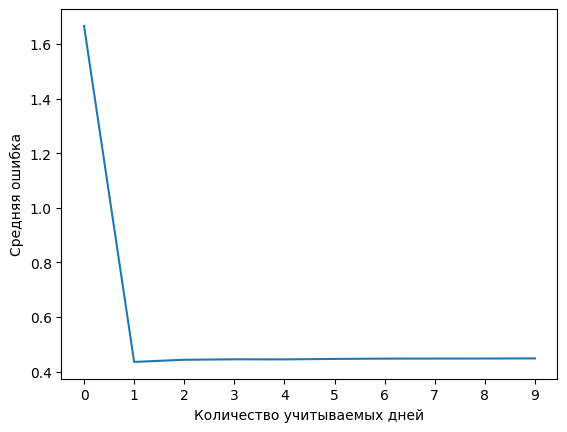

In [171]:
plt.plot(days_range, err)
plt.xticks(days_range)
plt.xlabel('Количество учитываемых дней')
plt.ylabel('Средняя ошибка')
plt.show()

In [202]:
X1, y1 = gen_data(X, y, 1)

In [203]:
print(f'MAE: {-cross_val_score(Lasso(alpha=0.05, max_iter=2000), X1, y1, cv=3, scoring="neg_mean_absolute_error").mean()}')
print(f'RMSE: {-cross_val_score(Lasso(alpha=0.05, max_iter=2000), X1, y1, cv=3, scoring="neg_root_mean_squared_error").mean()}')
print(f'R2: {cross_val_score(Lasso(alpha=0.05, max_iter=2000), X1, y1, cv=3, scoring="r2").mean()}')

MAE: 0.43567278056384584
RMSE: 0.7872777156355396
R2: 0.9852270988485007


In [204]:
X1_scaled = StandardScaler().fit_transform(X1)

In [205]:
print(f'MAE: {-cross_val_score(Lasso(alpha=0.05, max_iter=2000), X1_scaled, y1, cv=3, scoring="neg_mean_absolute_error").mean()}')
print(f'RMSE: {-cross_val_score(Lasso(alpha=0.05, max_iter=2000), X1_scaled, y1, cv=3, scoring="neg_root_mean_squared_error").mean()}')
print(f'R2: {cross_val_score(Lasso(alpha=0.05, max_iter=2000), X1_scaled, y1, cv=3, scoring="r2").mean()}')

MAE: 0.44122619972631494
RMSE: 0.7860176506362923
R2: 0.9852736838986521


In [206]:
model = Lasso(alpha=0.05, max_iter=2000).fit(X1, y1)
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(model, f)